## Fake News Classification

We will fine tune a BERT model for classifying a News as Fake or Real. 

[Article -1 ]( https://towardsdatascience.com/bert-text-classification-using-pytorch-723dfb8b6b5b )

[Article -2](https://towardsdatascience.com/fine-tuning-bert-and-roberta-for-high-accuracy-text-classification-in-pytorch-c9e63cf64646)

In [1]:
# Libraries

import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

from torchtext.data import Field,TabularDataset,BucketIterator,Iterator
# from transformers import AutoModelForSequenceClassification,AutoTokenizer,AutoConfig
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm.notebook import tqdm_notebook as tqdm

import gc
gc.collect()
torch.cuda.empty_cache()


import warnings
warnings.filterwarnings('ignore')

In [2]:
df_news = pd.read_csv('../Data/news/news.csv',index_col= 'Unnamed: 0' )
df_news.head()

,title,text,label
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [3]:
df_news.label.value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

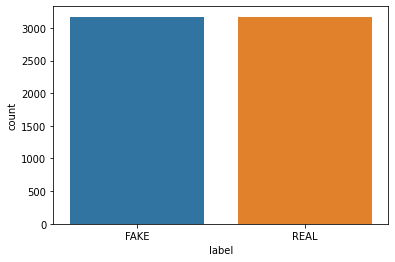

In [4]:
sns.countplot(x= 'label',data = df_news)
plt.show()

In [5]:
df_news['label'] = df_news['label'].apply(lambda x: 1 if x == 'FAKE' else 0)

In [6]:
df_news.label.value_counts()

0    3171
1    3164
Name: label, dtype: int64

In [7]:
df_news['titletext'] = df_news['title'] + ". " + df_news['text']

In [8]:
df_news = df_news.reindex(columns=['label', 'title', 'text', 'titletext'])


In [9]:
first_n_words = 200
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [10]:
df_news['text'] = df_news['text'].apply(trim_string)
df_news['titletext'] = df_news['titletext'].apply(trim_string) 

In [11]:
df_news.drop( df_news[df_news.text.str.len() < 5].index, inplace=True)

In [12]:
df_news_train,df_news_test = train_test_split(df_news, train_size = 0.8,stratify = df_news.label)

In [13]:
df_news_train,df_news_validation = train_test_split(df_news_train, train_size = 0.7,stratify = df_news_train.label)

In [14]:
df_news_train.to_csv('../Data/news/news_train.csv',index=False)
df_news_test.to_csv('../Data/news/news_test.csv',index=False)
df_news_validation.to_csv('../Data/news/news_validation.csv',index=False)

In [15]:
#  Check for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Working on device: {device}, model: {torch.cuda.get_device_name(0)}')

Working on device: cuda, model: GeForce RTX 2060


### Download Model

In [16]:
# model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',
#                                           num_labels = 2)

# tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = 'bert-base-uncased')

# model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path = 'bert-base-uncased',config = model_config)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
MAX_SEQ_LENGTH = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

In [18]:
# Fields

label_field = Field(sequential=False,use_vocab=False,batch_first=False,dtype=torch.float)

text_field = Field(use_vocab=False,tokenize=tokenizer.encode,lower=False,include_lengths=False,batch_first=True,fix_length=MAX_SEQ_LENGTH,pad_token=PAD_INDEX,unk_token=UNK_INDEX)

In [19]:
fields = [('label',label_field),('title',text_field),('text',text_field),('titletext',text_field)]
# fields = {'text' : ('text', text_field), 'label' : ('label', label_field)}


In [20]:
# Tabular Dataset

train_data,valid_data,test_data = TabularDataset.splits(path = '../Data/news/',train='news_train.csv',validation='news_validation.csv',test='news_test.csv',format = 'CSV',fields = fields,skip_header=True)

# train_data, valid_data, test_data = TabularDataset(path=f"../Data/news/news.csv", 
#                                                    format='CSV', 
#                                                    fields=fields, 
#                                                    skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
#                                                                             stratified=True, 
#                                                                             strata_field='label')



Token indices sequence length is longer than the specified maximum sequence length for this model (529 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (854 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (866 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [21]:
# Iterators

train_iter = BucketIterator(train_data,batch_size = 16,sort_key = lambda x: len(x.text),
                            device = device,train=True,sort=True,sort_within_batch=False,shuffle=True)
valid_iter = BucketIterator(valid_data,batch_size = 16,sort_key = lambda x: len(x.text),
                            device = device,train=True,sort=True,sort_within_batch=False,shuffle=True)
test_iter = Iterator(test_data,train=False,batch_size = 16,device = device,sort=False, shuffle=False)

### Model 

In [22]:
class NewsBert(nn.Module):

    def __init__(self):

        super(NewsBert,self).__init__()
        self.encoder = BertForSequenceClassification.from_pretrained("bert-base-uncased")

    def forward(self,text,label):
        loss,text_features = self.encoder(text,labels = label)[:2]

        return loss, text_features   
        

In [30]:
def save_checkpoint(save_path,model,valid_loss):

    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path,model):

    state_dict = torch.load(load_path,map_location= device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

In [24]:
torch.cuda.empty_cache()

In [25]:
def save_metrics(save_path,train_loss_list,valid_loss_list,global_steps_list):

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model metrics saved to ==> {save_path}')

def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [26]:
### Training

def training(model, 
             optimizer,
             train_loader, 
             valid_loader ,
             eval_every ,
             num_epochs = 4,
             criterion = nn.BCELoss(),
             file_path = '../model/NewsBert/',
             best_valid_loss = float("Inf")):


    running_loss = 0.0
    validation_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []  


    model.train()
    for epoch in tqdm(range(num_epochs)):
       for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor).to(device)
            titletext = titletext.type(torch.LongTensor).to(device)

            loss,_ = model(titletext,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():

                    for (labels, title, text, titletext), _ in valid_loader:

                        labels = labels.type(torch.LongTensor).to(device)
                        titletext = titletext.type(torch.LongTensor).to(device)

                        loss,_ = model(titletext,labels)

                        validation_running_loss += loss.item()
            
                average_train_loss = running_loss / eval_every
                average_valid_loss = validation_running_loss / len(valid_loader)

                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)


                # resetting running values
                running_loss = 0.0                
                validation_running_loss = 0.0
                model.train()

                 # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                 # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)


    print('Finished Training!')

In [27]:
classification_model = NewsBert().to(device)
optimizer = torch.optim.Adam(classification_model.parameters(),lr = 2e-5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [28]:
training(model= classification_model,optimizer=optimizer, train_loader = train_iter, valid_loader = valid_iter, eval_every = len(train_iter) // 2)

Epoch [1/4], Step [110/884], Train Loss: 0.6379, Valid Loss: 0.3895
Model saved to ==> ../model/NewsBert//model.pt
Model metrics saved to ==> ../model/NewsBert//metrics.pt
Epoch [1/4], Step [220/884], Train Loss: 0.2360, Valid Loss: 0.2004
Model saved to ==> ../model/NewsBert//model.pt
Model metrics saved to ==> ../model/NewsBert//metrics.pt
Epoch [2/4], Step [330/884], Train Loss: 0.2838, Valid Loss: 0.2029
Epoch [2/4], Step [440/884], Train Loss: 0.0897, Valid Loss: 0.3228
Epoch [3/4], Step [550/884], Train Loss: 0.2139, Valid Loss: 0.2698
Epoch [3/4], Step [660/884], Train Loss: 0.0406, Valid Loss: 0.3228
Epoch [4/4], Step [770/884], Train Loss: 0.3043, Valid Loss: 0.2075
Epoch [4/4], Step [880/884], Train Loss: 0.0330, Valid Loss: 0.1440
Model saved to ==> ../model/NewsBert//model.pt
Model metrics saved to ==> ../model/NewsBert//metrics.pt

Finished Training!


### Evaluation

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model,test_loader):

    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels,title,text,titletext),_ in test_loader:
            
            labels = labels.type(torch.LongTensor).to(device)
            titletext = titletext.type(torch.LongTensor).to(device)
            _,output = model(titletext,labels)

            y_pred.extend(torch.argmax(output,1).tolist())
            y_true.extend(labels.tolist())

    
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

In [31]:
# Load Model and Evaluate

best_model = NewsBert().to(device)
load_checkpoint('../model/NewsBert/'+'model.pt',best_model)

evaluate(best_model, test_iter)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== ../model/NewsBert//metrics.pt


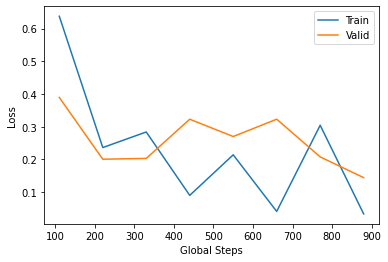

In [32]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('../model/NewsBert/' + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 